# Question

Develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan. Data for the case is available in CSV format having 6362620 rows and 10 columns.

## Workflow
- Reading and understanding the data
- EDA
- Handling data imbalance
- Building logistic regression models
- Model evaluation
- Building Random forest model
- Evaluating rf model


In [24]:
# importing libraries
import numpy as np,pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [25]:
import warnings
warnings.filterwarnings('ignore')

##  Reading and understanding the data

In [26]:
#storing data to df
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [27]:
#number of rows and columns in df
df.shape

(6362620, 11)

-  There are 6362620 rows and 11 columns in the data set



In [28]:
# dropping duplicate rows
df.drop_duplicates(inplace =True)
df.shape

(6362620, 11)

- Since the shape of df before and after dropping duplicates are the same, we could say that there are no duplicate rows in df

In [29]:
#describing numerical columns
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [30]:
# checking data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 582.5+ MB


#### Outlier analysis

- Since the bank data has only account balances and transfer amounts, it can take any real number
- so there is no need for analyzing outliers separately. I already described the numerical columns, and they look satisfactory

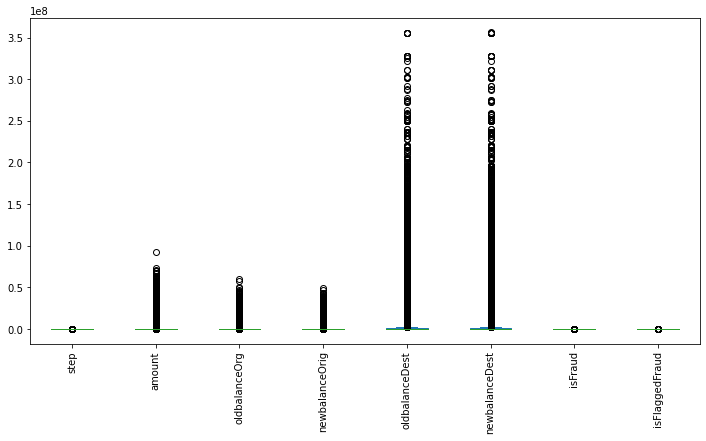

In [31]:
df.select_dtypes('number').plot.box(figsize=(12,6))
plt.xticks(rotation=90)
plt.show()                                    

#### Handling missing values and further cleaning the data

In [32]:
# Checking for null values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

    # there are no missing values

In [33]:
#### 'oldbalanceDest' and 'newbalanceDest'

Tthere is no information for customers that start with M  (given in quesion)

In [34]:
# number of customers that start with M
df[df.nameDest.str.startswith('M')].shape

(2151495, 11)

In [35]:
df[df.nameDest.str.startswith('M')][['oldbalanceDest','newbalanceDest']].describe()

,oldbalanceDest,newbalanceDest
count,2151495.0,2151495.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


- For 'oldbalanceDest' and 'newbalanceDest',there is no information for customers that start with M (Merchants).

In [36]:
100*df[df.nameDest.str.startswith('M')].shape[0]/df.shape[0]

33.81460781879163

In [37]:
# checking how many of them belong to normal/fraud categories
df[df.nameDest.str.startswith('M')]['isFraud'].value_counts()

0    2151495
Name: isFraud, dtype: int64

- There are  2151495 transactions where recipients are Merchants
- We do not have information about their  'oldbalanceDest' and 'newbalanceDest' values.
- However, none of these transactions where fraudulent, so it may not have s significant impact on the performance of the model. We could either impute the missing values or simply drop the rows.

In [38]:
# dropping transacrions where recipients are Merchants
df = df[~df.nameDest.str.startswith('M')]

In [39]:
df.shape

(4211125, 11)

In [40]:
### Type of transaction

In [41]:
df.type.value_counts()

CASH_OUT    2237500
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [42]:
df.groupby('type')['isFraud'].value_counts()

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
TRANSFER  0           528812
          1             4097
Name: isFraud, dtype: int64

<AxesSubplot:ylabel='isFraud'>

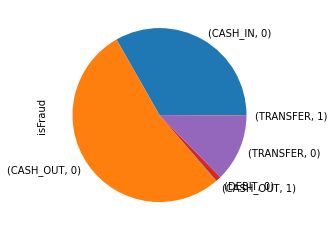

In [43]:
df.groupby('type')['isFraud'].value_counts().plot.pie()

- There are no fraudulent transactions in 'CASH_IN' or 'DEBIT' type of transactions
- So it makes sense to consider only 'CASH_OUT' and 'TRANSFER' (types having fraudulent transactions), while building the model. By doing so the accuracy of the model can be increased by focusing on the relevant data.

In [44]:
# for further analysis I am considering only those transactions where type is either 'CASH_OUT' or 'TRANSFER

df = df[(df.type=='CASH_OUT') | (df.type=='TRANSFER')]
df.shape

(2770409, 11)

In [45]:
##### "nameOrig" and 'nameDest'

In [46]:
df[df.isFraud==1].nameDest.value_counts()

C1193568854    2
C104038589     2
C200064275     2
C1497532505    2
C1601170327    2
              ..
C317811789     1
C24324787      1
C1053414206    1
C2013070624    1
C873221189     1
Name: nameDest, Length: 8169, dtype: int64

In [47]:
df[df.isFraud==1].nameOrig.value_counts()

C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
              ..
C570536992     1
C980546604     1
C58682758      1
C351713185     1
C1280323807    1
Name: nameOrig, Length: 8213, dtype: int64

- From above two observations it is clear that among the 8213 fraud transactions there is no originator or recipient who is involved in more than 2 fraud transactions, ie, no customer(names) is consistently being involved in fraudulent transactions.
- So I can remove these two variables from the data set


In [48]:
df.drop(["nameOrig", 'nameDest'],axis=1,inplace=True)
df.shape

(2770409, 9)

#### Sanity check

In [49]:
# checking number of rows with non zero transaction amount but zero 'oldbalanceOrg' and 'newbalanceOrig' 
df[(df.oldbalanceOrg==0)&(df.newbalanceOrig==0)&(df.amount!=0)].shape[0]

1308566

In [50]:
100*1308566/df.shape[0]

47.233675605298714

In [51]:
df[(df.oldbalanceOrg==0)&(df.newbalanceOrig==0)&(df.amount!=0)].isFraud.value_counts()

0    1308541
1         25
Name: isFraud, dtype: int64

- When the transaction amount is non zero, there must be some difference in balance of originator  before and after transaction
- But  there are 1308566 (47% of the data) transactions where amount is non zero but new and old balance of originators are being 0
- This means the the data is missing at these places
- I do not want to get rid of these rows,so I will simply keep them


In [52]:
df.loc[(df.oldbalanceOrg==0)&(df.newbalanceOrig==0)&(df.amount!=0),['oldbalanceOrg','newbalanceOrig']]= 0

In [53]:
### now  checking number of rows with non zero transaction amount but zero 'oldbalanceDest' and 'newbalanceDest'
df[(df.oldbalanceDest==0)&(df.newbalanceDest==0)&(df.amount!=0)].shape[0]

5776

- There are 5776 transactions where transaction amount is non zero but both bank balance of recipients are zero, before and after transaction.
- This may not be just entries where values are missing, there is a high chance that some of these are part of fraudulent transactions.
- So lets check how many fraud transactions are there with  transaction amount is non zero but both bank balance of recipients are zero, before and after transaction.

In [54]:
df[df.isFraud==1][(df.oldbalanceDest==0)&(df.newbalanceDest==0)&(df.amount!=0)].shape[0]

4070

- Among the 8213 fraudulent transactions 4070 are having non zero transaction amount yet zero bank balance before and after transaction.
- Here the actual values of missing values are unknown and it is difficult to estimate, but it is important to retain information about the presence of missing data
- So I will replace the missing values with -1

In [55]:
df.loc[(df.oldbalanceDest==0)&(df.newbalanceDest==0)&(df.amount!=0),['oldbalanceDest','newbalanceDest']] = -1

In [56]:
#### ISFRAUDFLAGGED

isFlaggedFraud - The business model flags transactions as illegal attempts if the transfer amount is more than 200,000 in a single transaction.

In [57]:
# checking number of transactions that were flagged illegal
df.isFlaggedFraud.value_counts()

0    2770393
1         16
Name: isFlaggedFraud, dtype: int64

In [58]:
# Number of transactions where transfer amount was above 200000
df[df.amount>200000].shape[0]

1197669

In [59]:
# Number of actual fraudulent transactions
df.isFraud.value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [60]:
# Number of transactions which were flagged fraud and was actually fraudulent
df[df.isFlaggedFraud==1].isFraud.value_counts()

1    16
Name: isFraud, dtype: int64

- There were only 16 transactions which were flagged fraud by IsFlaggedFraud variable
- However there were 1197669 transactions with transfer amount more than 200000.
- isFlaggedFraud variable is supposed to flag a transaction fraudulent if the transaction amount was above 200000 in a single transaction. There were 1673564 such transactions but the variable has flagged only 16 of them.
- There are 8213 fraudulent transactions in the dataset, in which only 16 were flagged by the variable isFlaggedFraud.
- From the above two points, it is pretty clear that the variable isFlaggedFraud is not much of a use. So I am dropping 'isFlaggedFraud' from df.

In [61]:
# dropping 'isFlaggedFraud' from df.
df.drop('isFlaggedFraud',axis=1,inplace=True)

##### Encoding the categorical variable

In [62]:
#Encoding categorical variable 'type'
df.type = df.type.map({'TRANSFER':1,'CASH_OUT':2})

#### Adding two new variables

In [63]:
# difference in bank balance before and after transaction
df['Org_bal_diff'] = abs(df.oldbalanceOrg - df.newbalanceOrig)
df['Dest_bal_diff'] = abs(df.oldbalanceDest - df.newbalanceDest)

#### checking for multicollinearity

<AxesSubplot:>

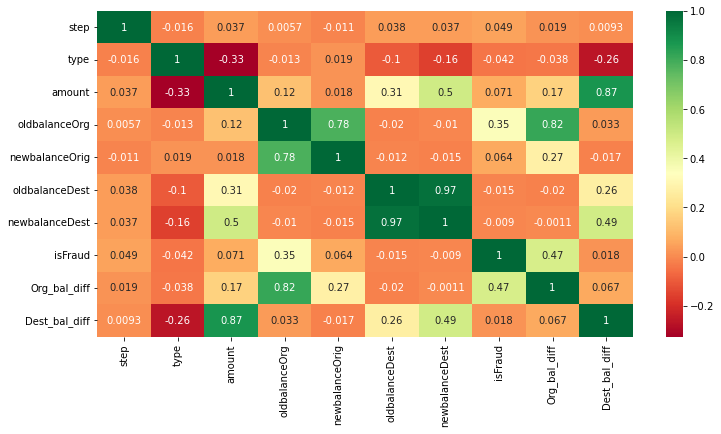

In [64]:
# Looking at correlation matrix to check for multicollinearity
plt.figure(figsize=[12,6])
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn')

- Highly correlated pairs
    - amount and Org_bal_diff
    - 'oldbalanceDest' and Org_bal_diff
- These variables are highly correlated, so there would be issues of multicollinearity while building the model.
- I will not remove the variables now, I will try to build a model with all the variables and then later remove one by one after checking their VIF values

#### checking for data imbalance

In [65]:
class_counts = df.isFraud.value_counts(normalize=True)
class_counts

0    0.997035
1    0.002965
Name: isFraud, dtype: float64

- Only ~0.3% of the transactions are fraudulent, so there is an imbalance in the data
- I will take care of this data imbalance using smote before building model

####class imbalance ratio <br>
The class imbalance ratio is calculated as the number of non-fraud transactions divided by the number of fraud transactions

In [66]:
class_counts = df["isFraud"].value_counts()
# Calculating the imbalance ratio
imbalance_ratio = class_counts[0] / class_counts[1]
imbalance_ratio

336.3199805186899

- Imbalance ratio is 336.32


# Building the model

In [67]:
# importing libraries
import statsmodels
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score,confusion_matrix

In [68]:
#putting response variable to y and features to X
y = df.isFraud
X = df.drop('isFraud',axis=1)


#### Feature scaling

In [69]:
# numerical columns in df
num_col = X.select_dtypes('number').columns

In [70]:
# scaling features using MinMax scaler
scaler = MinMaxScaler()
X[num_col] = scaler.fit_transform(X[num_col])
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Org_bal_diff,Dest_bal_diff
2,0.0,0.0,0.000002,0.000003,0.0,0.000000,0.000000e+00,0.000018,0.000000
3,0.0,1.0,0.000002,0.000003,0.0,0.000060,2.807575e-09,0.000018,0.000200
15,0.0,1.0,0.002479,0.000257,0.0,0.000014,1.446306e-04,0.001532,0.000439
19,0.0,0.0,0.002329,0.000012,0.0,0.000063,2.807575e-09,0.000070,0.000212
24,0.0,0.0,0.003372,0.000182,0.0,0.000018,7.634284e-03,0.001083,0.025669


- Features have been scaled properly
- So Now,none of the variables will have a disproportionate effect on the model’s results.

#### Train - test split

In [71]:
# Splitting the data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.7,random_state= 100,stratify = y)

In [72]:
# Checking shapes of train and test sets

In [73]:
X_train.shape,X_test.shape

((1939286, 9), (831123, 9))

In [74]:
y_train.shape,y_test.shape

((1939286,), (831123,))

#### <font color='green'>Handling Data Imbalance 

- With the help of SMOTE we can balance the data

In [75]:
# importing SMOTE
from imblearn.over_sampling import SMOTE
# instantiating smote
smote = SMOTE(random_state=42)
# shape of X_train and y_train before applying smote
print('shape of X_train and y_train before applying smote:', X_train.shape,y_train.shape)
#applying smote on data
X_train,y_train = smote.fit_resample(X_train,y_train)


shape of X_train and y_train before applying smote: (1939286, 9) (1939286,)


- Handling class imbalance by balancing class weights <br>
- here specifying the class_weight parameter as 'balanced' will automatically balance the weights based on the sample sizes. (handling data imbalance)

In [76]:
# checking shapes of X_train and y_train after applying smote
X_train.shape,y_train.shape

((3867074, 9), (3867074,))

### Building first logistic training model

In [77]:
# 1st logistic regression model
lgm1 = sm.GLM(y_train,(sm.add_constant(X_train)),fm = sm.families.Binomial())
lgm1 = lgm1.fit()

In [78]:
# Summary of first model
lgm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                isFraud   No. Observations:              3867074
Model:                            GLM   Df Residuals:                  3867064
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                         0.16279
Method:                          IRLS   Log-Likelihood:            -1.9772e+06
Date:                Tue, 14 Feb 2023   Deviance:                   6.2954e+05
Time:                        09:44:52   Pearson chi2:                 6.30e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5069      0.001    951.978      0.000       0.506       0.508
step               0.4513      0.001    563.480      0.000       0.450       0.453
type              -0.3293      0.000   -688.461      0.000      -0.330      -0.328
amount           -17.0132      0.039   -434.534      0.000     -17.090     -16.936
oldbalanceOrg    190.6385    351.997      0.542      0.588    -499.263     880.540
newbalanceOrig  -159.3904    292.922     -0.544      0.586    -733.507     414.727
oldbalanceDest   -83.1445      1.696    -49.019      0.000     -86.469     -79.820
newbalanceDest    78.2998      1.697     46.142      0.000      74.974      81.626
Org_bal_diff     -29.5637     59.075     -0.500      0.617    -145.348      86.221
Dest_bal_diff    -18.9265      0.504    -37.564      0.000     -19.914     -17.939
==================================================================================
"""

- There are few variables whose p-values are high, implying that these variables are statistically insignificant(p>0.05). So we need to eliminate some of the variables in order to build a better model.

- I will  manually eliminate features based on the p-values and VIFs).

In [79]:
# Checking for the VIF values of the feature variables.
# Creating a dataframe that will contain the names of all the feature variables and their respective VIFs

dff = pd.DataFrame()

dff['Features'] = X_train.columns
dff['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
dff['VIF'] = round(dff['VIF'],2)
dff = dff.sort_values(by = 'VIF',ascending = False)
dff

,Features,VIF
3,oldbalanceOrg,6.401651e+09
7,Org_bal_diff,3.413404e+09
4,newbalanceOrig,1.536911e+09
6,newbalanceDest,9.216190e+03
5,oldbalanceDest,6.303310e+03
8,Dest_bal_diff,1.556270e+03
2,amount,1.775000e+01
0,step,2.050000e+00
1,type,1.960000e+00


 - Vif values are very high for few features
 - So there are issues of multicollinearity
 - I will drop most insignificant feature in the model now, and again have a look at p values and vif

In [80]:
# dropping the featue with highest p value in the model
X_train.drop('Org_bal_diff',axis=1,inplace=True)

In [81]:
# second logistic regression model
lgm2 = sm.GLM(y_train,(sm.add_constant(X_train)),fm = sm.families.Binomial(), class_weight='balanced')
lgm2 = lgm2.fit()

In [82]:
lgm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                isFraud   No. Observations:              3867074
Model:                            GLM   Df Residuals:                  3867065
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                         0.16279
Method:                          IRLS   Log-Likelihood:            -1.9772e+06
Date:                Tue, 14 Feb 2023   Deviance:                   6.2954e+05
Time:                        09:45:26   Pearson chi2:                 6.30e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5069      0.001    951.978      0.000       0.506       0.508
step               0.4513      0.001    563.481      0.000       0.450       0.453
type              -0.3293      0.000   -688.462      0.000      -0.330      -0.328
amount           -17.0132      0.039   -434.534      0.000     -17.090     -16.937
oldbalanceOrg     14.4833      0.022    660.545      0.000      14.440      14.526
newbalanceOrig   -12.7988      0.019   -657.955      0.000     -12.837     -12.761
oldbalanceDest   -83.1452      1.696    -49.019      0.000     -86.470     -79.821
newbalanceDest    78.3006      1.697     46.143      0.000      74.975      81.626
Dest_bal_diff    -18.9267      0.504    -37.564      0.000     -19.914     -17.939
==================================================================================
"""

- All the variables in this model are significant as their p values are below 0.05

In [83]:
# Checking for the VIF values of the feature variables.
# Creating a dataframe that will contain the names of all the feature variables and their respective VIFs

dff = pd.DataFrame()

dff['Features'] = X_train.columns
dff['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
dff['VIF'] = round(dff['VIF'],2)
dff = dff.sort_values(by = 'VIF',ascending = False)
dff

,Features,VIF
6,newbalanceDest,9216.18
5,oldbalanceDest,6303.31
7,Dest_bal_diff,1556.27
3,oldbalanceOrg,23.77
2,amount,17.75
4,newbalanceOrig,6.62
0,step,2.05
1,type,1.96


- VIF values are high for few variables

In [84]:
# dropping the  feature with highest vif 
X_train.drop('newbalanceDest',axis=1,inplace=True)

In [85]:
#3rd logistic regression model
lgm3 = sm.GLM(y_train,(sm.add_constant(X_train)),fm = sm.families.Binomial(), class_weight='balanced')
lgm3 = lgm3.fit()

In [86]:
lgm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                isFraud   No. Observations:              3867074
Model:                            GLM   Df Residuals:                  3867066
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                         0.16288
Method:                          IRLS   Log-Likelihood:            -1.9783e+06
Date:                Tue, 14 Feb 2023   Deviance:                   6.2988e+05
Time:                        09:45:52   Pearson chi2:                 6.30e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5056      0.001    950.598      0.000       0.505       0.507
step               0.4535      0.001    566.883      0.000       0.452       0.455
type              -0.3296      0.000   -688.943      0.000      -0.331      -0.329
amount           -16.9963      0.039   -434.000      0.000     -17.073     -16.920
oldbalanceOrg     14.4787      0.022    660.161      0.000      14.436      14.522
newbalanceOrig   -12.7984      0.019   -657.752      0.000     -12.836     -12.760
oldbalanceDest    -4.8866      0.024   -205.063      0.000      -4.933      -4.840
Dest_bal_diff      4.2988      0.023    190.433      0.000       4.255       4.343
==================================================================================
"""

- All the features in this model are significant

In [87]:
# Checking for the VIF values of the feature variables.
# Creating a dataframe that will contain the names of all the feature variables and their respective VIFs

dff = pd.DataFrame()

dff['Features'] = X_train.columns
dff['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
dff['VIF'] = round(dff['VIF'],2)
dff = dff.sort_values(by = 'VIF',ascending = False)
dff

,Features,VIF
3,oldbalanceOrg,23.77
2,amount,17.75
4,newbalanceOrig,6.62
6,Dest_bal_diff,2.92
0,step,2.05
1,type,1.95
5,oldbalanceDest,1.24


- VIF values are high for few variables, So I am removing 'oldbalanceOrg' which has the highest VIF value in  X_train.

In [88]:
X_train.drop('oldbalanceOrg',1,inplace=True)

In [89]:
# 4th logistic regression model
lgm4 = sm.GLM(y_train,(sm.add_constant(X_train)),fm = sm.families.Binomial(), class_weight='balanced')
lgm4 = lgm4.fit()

In [90]:
lgm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                isFraud   No. Observations:              3867074
Model:                            GLM   Df Residuals:                  3867067
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                         0.18124
Method:                          IRLS   Log-Likelihood:            -2.1848e+06
Date:                Tue, 14 Feb 2023   Deviance:                   7.0087e+05
Time:                        09:46:24   Pearson chi2:                 7.01e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4329      0.001    788.583      0.000       0.432       0.434
step               0.5008      0.001    595.942      0.000       0.499       0.502
type              -0.2550      0.000   -520.072      0.000      -0.256      -0.254
amount             6.5517      0.017    384.228      0.000       6.518       6.585
newbalanceOrig    -1.2311      0.009   -137.936      0.000      -1.249      -1.214
oldbalanceDest    -9.5598      0.024   -398.285      0.000      -9.607      -9.513
Dest_bal_diff     -0.8219      0.022    -36.755      0.000      -0.866      -0.778
==================================================================================
"""

In [91]:
# Checking for the VIF values of the feature variables.
# Creating a dataframe that will contain the names of all the feature variables and their respective VIFs

dff = pd.DataFrame()

dff['Features'] = X_train.columns
dff['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
dff['VIF'] = round(dff['VIF'],2)
dff = dff.sort_values(by = 'VIF',ascending = False)
dff

,Features,VIF
2,amount,3.08
5,Dest_bal_diff,2.64
0,step,2.04
1,type,1.92
3,newbalanceOrig,1.27
4,oldbalanceDest,1.12


- All the variables in this model are significant 
- VIF values of features are  below 4,so there is no issue of multicollinearity

- The transaction amount has the highest coeifficient in the model, implying that if the transaction amount is very high there is a chance that transaction could be of fraudulent

- The logistic regression curve gives us the probability of a transaction being fraudulent. We can get these probabilities by simply using the 'predict' function 

In [92]:
X_train_sm = sm.add_constant(X_train)

In [93]:
# Getting the predicted values on the train set
y_train_pred = lgm4.predict(X_train_sm)
y_train_pred[:10]

0    0.341062
1    0.297322
2    0.553637
3    0.417857
4    0.674989
5    0.462012
6    0.187420
7    0.365075
8    0.231980
9    0.278003
dtype: float64

In [94]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.34106184, 0.29732151, 0.55363743, 0.41785681, 0.67498912,
       0.46201243, 0.18741997, 0.36507532, 0.23197994, 0.27800341])

In [95]:
##### Creating a dataframe with the actual isFraud flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'isFraud':y_train.values, 'prob_fraud':y_train_pred})
y_train_pred_final.head()

,isFraud,prob_fraud
0,0,0.341062
1,0,0.297322
2,0,0.553637
3,0,0.417857
4,0,0.674989


The logistic curve gives  just the probabilities and not the actual classification of fruadulent or not.So I need to find a threshold probability to classify transactions as 'fraud' and 'not fraud'. Here, to starts with I am choosing 0.5 as an arbitrary cutoff wherein if the probability of a particular transaction being fraud is less than 0.5,I would classify it as 'not fraud' and if it's greater than 0.5, I would classify it as 'Fraud'

In [96]:
y_train_pred_final['predicted'] = y_train_pred_final['prob_fraud'].apply(lambda x : 1 if x>0.5 else 0)

In [97]:
y_train_pred_final.head()

,isFraud,prob_fraud,predicted
0,0,0.341062,0
1,0,0.297322,0
2,0,0.553637,1
3,0,0.417857,0
4,0,0.674989,1


Since I am classifying the transactions into two classes, this will obviously have some errors. The classes of errors that would be there are:

    'fraud' transactions being (incorrectly) classified as 'not fraud'
    'not fraud' transactions being (incorrectly) classified as 'fraud'

 

To capture these errors, and to evaluate how well the model is, I will use 'Confusion Matrix'

### Model Evaluation: Accuracy, Sensitivity, and Specificity

In [98]:
from sklearn import metrics

In [99]:
confusion = metrics.confusion_matrix(y_train_pred_final.isFraud, y_train_pred_final.predicted)
print(confusion)

[[1590485  343052]
 [ 593265 1340272]]


In [100]:
# confusion matrix

##predicted     not fraud     fraud
##actual

#not fraud     1590485        343052

#fraud          593265           1340272

In [101]:
# Let's check the overall accuracy.
print(accuracy_score(y_train_pred_final.isFraud,y_train_pred_final.predicted))

0.7578745583870389


- We got an accuracy of 75.79%
- Our model is able to  correctly predict the lables  75.79% of the time (in train set)

#### Metrics beyond simply accuracy

In [102]:
TP = confusion[1,1] #true positive
TN = confusion[0,0] #true negative
FP = confusion[0,1] #false positive
FN = confusion[1,0] #flase negative

In [103]:
# Let's see the sensitivity of the logistic regression model
TP/(TP+FN)

0.6931711159393381

In [104]:
# Let's calculate specificity
TN/(TN+FP)

0.8225780008347396

- The model has sensitivity around 69.32% and specificity around 82.26%
- Model is able to correctly predict 69.32% of the fraud labels
- Model is able to correctly predict 82.26% of the 'not fraud' labels 

In [105]:
# Calculating false postive rate - predicting fraud when transaction is not fraud
FP/(FP+TN)

0.17742199916526036

In [106]:
# positive predictive value 
TP/(TP+FP)

0.7962056027241339

In [107]:
# Negative predictive value
TN/(TN+FN)

0.728327418431597

#### Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [108]:
# defining function for drawing ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [109]:
fpr,tpr,thresholds = metrics.roc_curve(y_train_pred_final.isFraud,y_train_pred_final['prob_fraud'],drop_intermediate= False)

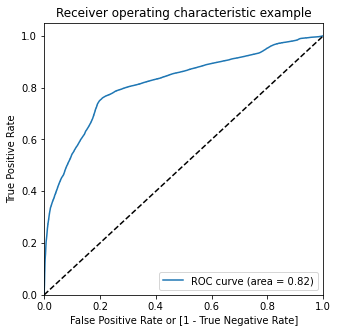

In [110]:
draw_roc(y_train_pred_final.isFraud,y_train_pred_final['prob_fraud'])

- This curve is towards the upper-left corner, there is good amont of area under the curve (AUC) indicating that the model is good. 
- The AUC score for train dataset is 0.82

#### Model Evaluation: Precision and Recall

In [111]:
from sklearn.metrics import precision_score, recall_score

In [112]:
# Precision Score
precision_score(y_train_pred_final.isFraud,y_train_pred_final.predicted)

0.7962056027241339

In [113]:
# Recall Score
recall_score(y_train_pred_final.isFraud,y_train_pred_final.predicted)

0.6931711159393381

- The model has high precision but relatively lower recall
- So I need to find an optimum cut-off to have a good balance between these two

In [114]:
# Let's create columns with different probability cutoffs 
number = [float(x/10) for x in range(10)]

for i in number:
    y_train_pred_final[i] = y_train_pred_final['prob_fraud'].apply(lambda j: 1 if j>i else 0)
    
y_train_pred_final.head()

,isFraud,prob_fraud,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.341062,0,1,1,1,1,0,0,0,0,0,0
1,0,0.297322,0,1,1,1,0,0,0,0,0,0,0
2,0,0.553637,1,1,1,1,1,1,1,0,0,0,0
3,0,0.417857,0,1,1,1,1,1,0,0,0,0,0
4,0,0.674989,1,1,1,1,1,1,1,1,0,0,0


In [115]:
# Now let's calculate precision, recall and accuracy for various probability cutoffs.
cutoff_df = pd.DataFrame(columns = ['prob','accuracy','preci','recall'])

for i in number:
    cm1 = metrics.confusion_matrix(y_train_pred_final.isFraud,y_train_pred_final[i])
    total1 = sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/ total1 #TN+TP/TOTAL
    precision = precision_score(y_train_pred_final.isFraud,y_train_pred_final[i])
    recall = recall_score(y_train_pred_final.isFraud,y_train_pred_final[i])
    cutoff_df.loc[i] = [i,accuracy,precision,recall]
print(cutoff_df)

     prob  accuracy     preci    recall
0.0   0.0  0.505029  0.502533  0.997775
0.1   0.1  0.512713  0.506465  0.995911
0.2   0.2  0.557433  0.531291  0.975152
0.3   0.3  0.628242  0.582598  0.904544
0.4   0.4  0.733172  0.699340  0.818030
0.5   0.5  0.757875  0.796206  0.693171
0.6   0.6  0.718450  0.847536  0.532734
0.7   0.7  0.667807  0.918300  0.368390
0.8   0.8  0.623011  0.956597  0.257716
0.9   0.9  0.572442  0.973292  0.148972


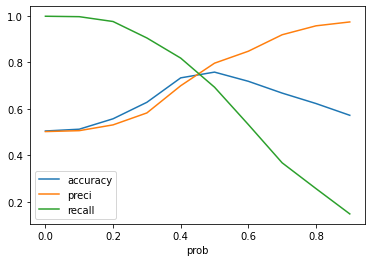

In [116]:
# Let's plot accuracy precision and recall for various probabilities.
cutoff_df.plot.line(x= 'prob',y =['accuracy','preci','recall'])
plt.show()

- Our initial probability cutoff was 0.5
- But From the curve above, we can see that the optimum point is above 0.4 but less than 0.5
- So let's plot the same for values between 0.4 and 0.5

In [117]:
number=[0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5]
for i in number:
    y_train_pred_final[i] = y_train_pred_final['prob_fraud'].apply(lambda j: 1 if j>i else 0)
    
cutoff_df = pd.DataFrame(columns = ['prob','accuracy','preci','recall'])

for i in number:
    cm1 = metrics.confusion_matrix(y_train_pred_final.isFraud,y_train_pred_final[i])
    total1 = sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/ total1 #TN+TP/TOTAL
    precision = precision_score(y_train_pred_final.isFraud,y_train_pred_final[i])
    recall = recall_score(y_train_pred_final.isFraud,y_train_pred_final[i])
    cutoff_df.loc[i] = [i,accuracy,precision,recall]
print(cutoff_df)


      prob  accuracy     preci    recall
0.40  0.40  0.733172  0.699340  0.818030
0.41  0.41  0.742547  0.713810  0.809751
0.42  0.42  0.752524  0.729758  0.802067
0.43  0.43  0.760432  0.744587  0.792825
0.44  0.44  0.767032  0.760015  0.780527
0.45  0.45  0.773250  0.775865  0.768510
0.46  0.46  0.775638  0.787679  0.754711
0.47  0.47  0.774094  0.793210  0.741496
0.48  0.48  0.768890  0.794701  0.725098
0.49  0.49  0.764104  0.795720  0.710649
0.50  0.50  0.757875  0.796206  0.693171


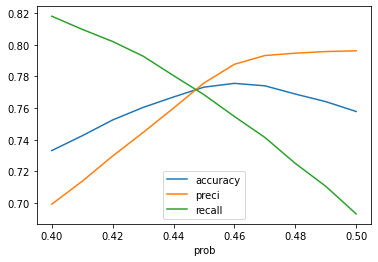

In [118]:
# Let's plot accuracy precision and recall for various probabilities.
cutoff_df.plot.line(x= 'prob',y =['accuracy','preci','recall'])
plt.show()

- Optimum probability cut off is 0.45

In [119]:
# final prediction using cutoff of 0.45
y_train_pred_final['final_predicted'] = y_train_pred_final['prob_fraud'].apply(lambda x: 1 if x>0.45 else 0)

In [120]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.isFraud,y_train_pred_final.final_predicted)

0.7732497490350585

In [121]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.isFraud,y_train_pred_final.final_predicted)

In [122]:
confusion2

array([[1504272,  429265],
       [ 447595, 1485942]], dtype=int64)

In [123]:
TP = confusion2[1,1] # True positive
TN = confusion2[0,0] # True negative
FP = confusion2[0,1] # False positive
FN = confusion2[1,0] # False negative
# Let's see the sensitivity of our logistic regression model
print('sensitivity : ', TP/float(TP+ FN))
# Let us calculate specificity
print('specificity : ',TN/float(TN+FP))

sensitivity :  0.7685097311300482
specificity :  0.7779897669400689


In [124]:
# Precision Score
precision_score(y_train_pred_final.isFraud,y_train_pred_final.final_predicted)

0.7758649587224775

In [125]:
# Recall Score
recall_score(y_train_pred_final.isFraud,y_train_pred_final.final_predicted)

0.7685097311300482

- Earlier with 0.5 cut-off
    - accuracy: 75.79%
    - sensitivity: 69.32%
    - specificity : 82.26%
    - recall :     69.32
    - precision :  79.62%
   
- After choosing the optimum cut-off at 0.45
    - accuracy: 77.32%
    - sensitivity: 76.85%
    - specificity : 77.8%
    - recall :     76.85%
    - precision :  77.59%

- Optimum probability cut off is 0.45

####  Making predictions on the test set

In [126]:
X_test_sm = sm.add_constant(X_test[X_train.columns])

In [127]:
# Making predictions on the test set
y_test_pred = lgm4.predict(X_test_sm)
y_test_pred[:10]

4139690    0.288265
6226732    0.828458
2331293    0.304755
5312364    0.697785
5044421    0.420396
4981499    0.704677
529520     0.201881
1359426    0.166684
3367213    0.347272
2653076    0.305337
dtype: float64

In [128]:
# Converting y_test_pred(which is an array) to a dataframe 
y_test_pred_df = pd.DataFrame(y_test_pred)
y_test_pred_df.head()

,0
4139690,0.288265
6226732,0.828458
2331293,0.304755
5312364,0.697785
5044421,0.420396


In [129]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,isFraud
4139690,0
6226732,0
2331293,0
5312364,0
5044421,0


In [130]:
#appending both
y_test_pred_final = pd.concat([y_test_df,y_test_pred_df],axis=1)
y_test_pred_final = y_test_pred_final.rename(columns = {0:'prob_fraud'})
y_test_pred_final.head()

,isFraud,prob_fraud
4139690,0,0.288265
6226732,0,0.828458
2331293,0,0.304755
5312364,0,0.697785
5044421,0,0.420396


In [131]:
y_test_pred_final['final_predicted'] = y_test_pred_final.prob_fraud.apply(lambda x: 1 if x> 0.45 else 0)
y_test_pred_final.head()

,isFraud,prob_fraud,final_predicted
4139690,0,0.288265,0
6226732,0,0.828458,1
2331293,0,0.304755,0
5312364,0,0.697785,1
5044421,0,0.420396,0


In [132]:
# Let's check the overall accuracy on test set
metrics.accuracy_score(y_test_pred_final.isFraud,y_test_pred_final.final_predicted)

0.7782494287849091

In [133]:
# let's have a look at the confusion matrix
confusion3 = metrics.confusion_matrix(y_test_pred_final.isFraud, y_test_pred_final.final_predicted)
confusion3 

array([[644970, 183689],
       [   613,   1851]], dtype=int64)

In [134]:
# Precision Score
precision_score(y_test_pred_final.isFraud,y_test_pred_final.final_predicted)

0.009976285437102512

In [135]:
# Recall Score
recall_score(y_test_pred_final.isFraud,y_test_pred_final.final_predicted)

0.7512175324675324

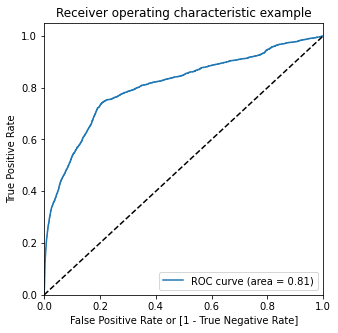

In [136]:
### ROC CURVE for test set
fpr,tpr,thresholds = metrics.roc_curve(y_test_pred_final.isFraud,y_test_pred_final['prob_fraud'],drop_intermediate= False)
draw_roc(y_test_pred_final.isFraud,y_test_pred_final['prob_fraud'])

# Random Forest Model

In [137]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Org_bal_diff,Dest_bal_diff
2,0.0,0.0,0.000002,0.000003,0.0,0.000000,0.000000e+00,0.000018,0.000000
3,0.0,1.0,0.000002,0.000003,0.0,0.000060,2.807575e-09,0.000018,0.000200
15,0.0,1.0,0.002479,0.000257,0.0,0.000014,1.446306e-04,0.001532,0.000439
19,0.0,0.0,0.002329,0.000012,0.0,0.000063,2.807575e-09,0.000070,0.000212
24,0.0,0.0,0.003372,0.000182,0.0,0.000018,7.634284e-03,0.001083,0.025669


In [138]:
from imblearn.over_sampling import SMOTE

In [139]:
# Splitting the data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.7,random_state= 100,stratify = y)
# Checking shapes of train and test sets
print("shapes of X train and X test sets: {} & {}".format(X_train.shape,X_test.shape))
print("shapes of y train and y test sets: {} & {}".format(y_train.shape,y_test.shape))
# Handling Data Imbalance 
# instantiating smote
smote = SMOTE(random_state=42)
#applying smote on data
X_train,y_train = smote.fit_resample(X_train,y_train)
# Checking shapes of train and test sets after applying smote
print("shapes of X train and X test sets after smote : {} & {}".format(X_train.shape,X_test.shape))
print("shapes of y train and y test sets after smote : {} & {}".format(y_train.shape,y_test.shape))

shapes of X train and X test sets: (1939286, 9) & (831123, 9)
shapes of y train and y test sets: (1939286,) & (831123,)
shapes of X train and X test sets after smote : (3867074, 9) & (831123, 9)
shapes of y train and y test sets after smote : (3867074,) & (831123,)


In [140]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42,n_jobs=-1)
# fitting Random forest model with default hyperparameters
rf.fit(X_train,y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

#### Predictions on test set

In [141]:
from sklearn import metrics

In [142]:
# prediction on test set
y_test_rf_pred = rf.predict(X_test)

# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_rf_pred)
print(confusion)

[[827643   1016]
 [    56   2408]]


In [143]:
#accuracy on test set
print('accuracy on test set : {}'.format((accuracy_score(y_test,y_test_rf_pred))))
# recall score
print('recall on test set : {}'.format(round(recall_score(y_test,y_test_rf_pred),2)))
# precision score
print('precision on test set : {}'.format(round(precision_score(y_test,y_test_rf_pred),2)))
# auc score
print('auc score on test set : {}'.format(round(metrics.roc_auc_score(y_test,y_test_rf_pred),2)))
# f1 score
print('f1 score on test set : {}'.format(round(metrics.f1_score(y_test,y_test_rf_pred),2)))

accuracy on test set : 0.9987101788784573
recall on test set : 0.98
precision on test set : 0.7
auc score on test set : 0.99
f1 score on test set : 0.82


- This model has better scores than the logistic regression model

- For predicting fraudulent transactions, first, I made a logistic regression model
    - it has an accuracy of 75.79% on the train set and  77.32%   on the test set
    -  logistic regression model has similar precision and recall on the training set but a much lower precision score on the test set, which could be a sign of overfitting. 
    - The transaction amount has the highest coefficient in the model, implying that if the transaction amount is very high, there is a chance that the transaction could be fraudulent
    - Other features used in the model are 'step', 'type', 'amount', 'newbalanceOrig', 'oldbalanceDest', and 'Dest_bal_diff'. 
    - The financial company can focus on these features for predicting fraudulent transactions
       
- Fraudulent transactions are happening only on payment method types - 'Transfer' & 'Cash_out', so the company needs to keep an eye on these transactions
- The random Forest model was performing well on the test set
    - accuracy on test set: 0.9987101788784573
    - recall on test set: 0.98
    - precision on test set: 0.7
    - auc score on test set: 0.99
    - f1 score on test set: 0.82
- we can also build better models using different algorithms and then retrain & maintain these models after regular intervals to keep fraudulent transactions away.